# MNIST

Warning: since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this and keep the same code as in the book, we use as_frame=False

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,as_frame=False)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure includ‐
ing:

• A DESCR key describing the dataset

• A data key containing an array with one row per instance and one column per
feature

• A target key containing an array with the label

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape


(70000, 784)

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black).

 Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using
Matplotlib’s imshow() function:

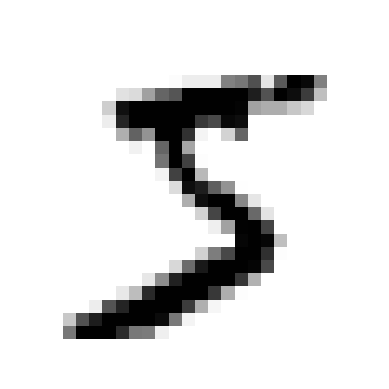

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


In [4]:
y[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)


# Training a Binary Classifer
Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:


In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [8]:
print(y_train_5)

[ True False False ...  True False False]


now x_train contains all the training data (i.e  X[:60000]  ) and y_train_5 contains is x_train[0] value true (if 5) or false  

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

Note: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as max_iter and tol. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3,random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

# Measuring Accuracy Using Cross-Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42,shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
 print(y_train_5)
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 X_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred))

[ True False False ...  True False False]
0.9669
[ True False False ...  True False False]
0.91625
[ True False False ...  True False False]
0.96785


# using library

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
  pass
 def predict(self, X):
  return np.zeros((len(X), 1), dtype=bool)

In [15]:
 never_5_clf = Never5Classifier()
 cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others)

In [16]:
never_5_clf.fit(X_train,y_train_5)

In [17]:
never_5_clf.predict(X_test)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

# Confusion Matrix

### The general idea is to count the number of times instances of class A are
### classified as class B. For example, to know the number of times the classifier confused
### images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
### matrix.

Now you are ready to get the confusion matrix using the confusion_matrix() func‐
tion. Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred):


In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

# ###  The first row of this matrix considers non-5 images (the nega‐tive class): 53,057 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives), while the remaining 4,096 were correctly classi‐ fied as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diago‐ nal (top left to bottom right):

In [20]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)
   

array([[54579,     0],
       [    0,  5421]], dtype=int64)

# Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)


0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1
score,

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then make predictions based on those scores using any
threshold you want:

below y_scores are the scores made by decision function if the scores is greater than threshold then it is considered as true positive 

# decision function generates score which if it is greater than threshold then it is classified in one classification otherwise another 

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)


[2164.22030239]


In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)


In [40]:
print(y_some_digit_pred)

[ True]


In [44]:
 threshold = 2162
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
 method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

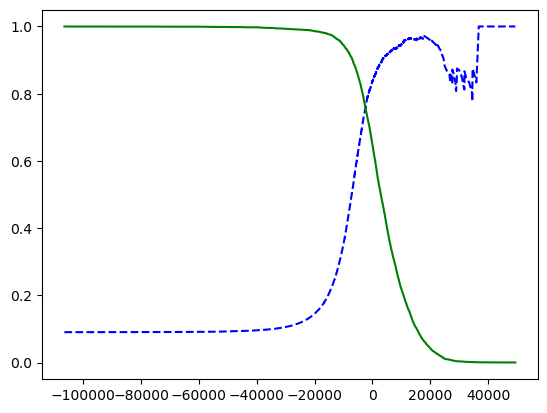

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  [...] # highlight the threshold, add the legend, axis label and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

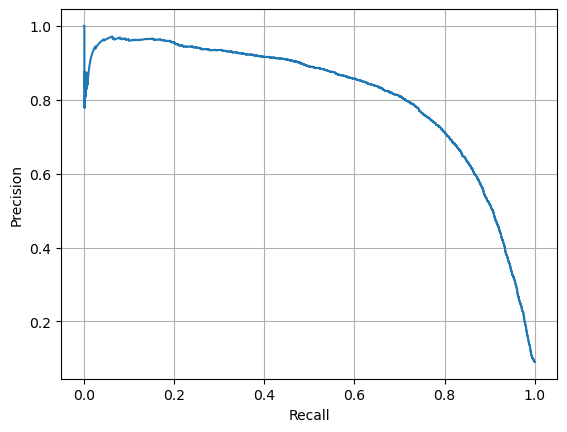

In [48]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

## So let’s suppose you decide to aim for 90% precision. You look up the first plot and
find that you need to use a threshold of about 8,000. To be more precise you can
search for the lowest threshold that gives you at least 90% precision (np.argmax()
will give us the first index of the maximum value, which in this case means the first
True value):

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

In [30]:
threshold_90_precision 

3370.0194991439594

In [31]:
y_scores


array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [32]:
print(y_scores)

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [35]:
 precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## If someone says “let’s reach 99% precision,” you should ask, “at
## what recall?”

## The ROC Curve

 the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate, 
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.

In [51]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

To plot the ROC curve, you first need to compute the TPR and FPR for various thres‐
hold values, using the roc_curve() function:

In [52]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


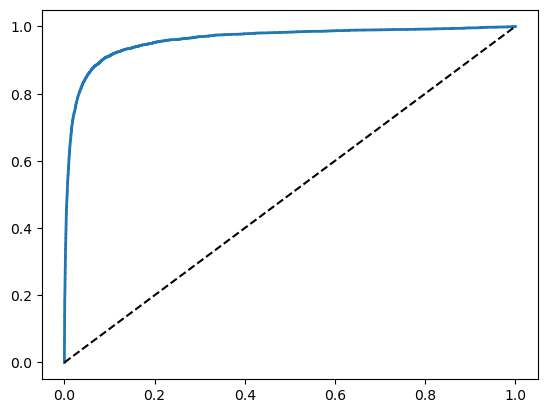

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()
